# Generative Modelling with VAEs and GANs

From a practical perspective, neural networks have primarily been used for supervised learning, with applications ranging from activity recognition in videos to language translation. However, labelled data is sparse or nonexistent in many situations, so we'd like to make use of unsupervised learning to make sense of the vast amount of unlabelled data in the world. Here we'll look at two common types of deep generative models - variational autoencoders (VAEs) and generative adversarial networks (GANs) - that can learn to generate samples from a dataset.

## Data

We'll use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which comprises of 70,000 28x28 grayscale images of handwritten digits. Apart from the underlying classes (0-9), there's a bunch of factors of variation such as line thickness and slant:

![MNIST samples](https://qph.fs.quoracdn.net/main-qimg-d01751bdf7dab3d9a5949f226a35b7ba)

This dataset is relatively easy to model, so we'll do so with the 60,000 samples from the training set.

In [1]:
import os
import time
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from IPython.display import clear_output, display
%matplotlib inline

In [2]:
latent_size = 10
batch_size = 128

data_path = os.path.join(os.path.expanduser('~'), '.torch', 'datasets', 'mnist')
train_data = datasets.MNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(data_path, train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

## VAEs

### Model

The VAE (somewhat misnamed) consists of an autoencoder with a stochastic bottleneck layer, trained via variational inference. The encoder and decoder will make use of convolutions and transposed (also known as fractionally-strided) convolutions, respectively. The latent encoding in the middle of the autoencoder - the variational posterior - will be a simple diagonal covariance Gaussian. In addition, we'll make use of the "reparameterisation trick", where the stochastic latents are decomposed into a combination of deterministic variables and another source of noise - so there is no longer a need to devise a gradient estimator for backpropagating through a sampling process.

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, stride=2, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc_mu = nn.Linear(32 * 4 * 4, latent_size)
        self.fc_log_var = nn.Linear(32 * 4 * 4, latent_size)
        self.fc_dec = nn.Linear(latent_size, 32 * 4 * 4)
        self.conv4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=2, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8, 1, 5, stride=2, padding=2, output_padding=1)

    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        mu, log_var = self.fc_mu(x), None
        z = mu
        if self.training:
            log_var = self.fc_log_var(x)
            z = z + log_var.mul(0.5).exp() * torch.randn_like(z)
        return z, mu, log_var
    
    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(-1, 32, 4, 4)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        return torch.sigmoid(self.conv6(x))

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        x = self.decode(z)
        return x, z, mu, log_var

### Training, Sampling and Interpolating

To train the model we will optimise the variational or evidence lower bound (ELBO). The ELBO consists of minimising the reconstruction error of the input sample (as with a normal autoencoder), as well as the Kullback-Leibler (KL) divergence between the variational posterior and the prior - which we set to a unit Gaussian. Because of the form of our prior and posterior we can actually construct an analytical form of the KL to minimise.

Once the model is trained we can sample a latent code from our prior and pass this through the decoder to form a sample of the data. Although the posterior may not match the prior, this is an OK assumption to make. Other than picking random samples, we can also pick a dimension of the latent code to interpolate in (keeping all other dimensions fixed), which would reveal what that dimension is coding for. We'll plot random samples on the left and interpolations on the right.

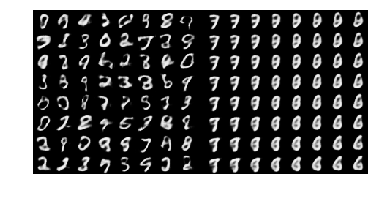

In [4]:
model = VAE()
optimiser = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
z_samples = torch.randn(64, latent_size)
z_interp = torch.zeros(64, latent_size)
grid_x, grid_y = torch.meshgrid([torch.linspace(-1.5, 1.5, 8), torch.linspace(-1.5, 1.5, 8)])
z_interp[:, 0] = grid_y.contiguous().view(-1)
z_interp[:, 1] = grid_x.contiguous().view(-1)
black_bar = torch.zeros(3, 8 * 28, 10)

plt.axis('off')

def train():
    model.train()
    for i, (x, _) in enumerate(train_loader):
        optimiser.zero_grad()
        x_hat, z, mu, log_var = model(x)
        bce_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_dist = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp())
        (bce_loss + kl_dist).div(batch_size).backward()
        optimiser.step()


def sample():
    model.eval()
    with torch.no_grad():
        samples = make_grid(model.decode(z_samples), padding=0)
        interps = make_grid(model.decode(z_interp), padding=0)
        plt.imshow(np.transpose(torch.cat([samples, black_bar, interps], 2).numpy(), [1, 2, 0]))
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.1)
        

for epoch in range(epochs):
    train()
    sample()
clear_output(wait=True)

To see how latent samples from the prior may differ from latent samples from the learned posterior, we can feed the first batch of generated data samples into the network repeatedly. This acts as a form of Markov chain Monte Carlo (MCMC) sampling, making both the latent and data samples more likely under the model. With just a few steps of MCMC sampling, the new data samples are more recognisable as digits, but also less diverse.

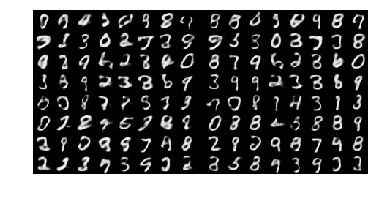

In [5]:
plt.axis('off')

model.eval()
with torch.no_grad():
    orig_samples = model.decode(z_samples)
    samples = orig_samples
    for _ in range(10):
        samples = model(samples)[0]
    orig_samples = make_grid(orig_samples, padding=0)
    samples = make_grid(samples, padding=0)
plt.imshow(np.transpose(torch.cat([orig_samples, black_bar, samples], 2).numpy(), [1, 2, 0]))
display(plt.gcf())
clear_output(wait=True)

## GANs

### Models

GANs involve two separate models - a generator and a discriminator - trained via a two-player zero sum game. The generator is an implicit generative model that takes a source of noise as input and produces a data sample. The discriminator takes (real or fake) data samples as input and outputs the probability that they are real samples. We can construct the generator out of transposed convolutions and the discriminator out of regular convolutions; in particular, we'll follow some architectural choices proposed under the name of "deep convolutional generative adversarial network" (DCGAN).

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(latent_size, 32, 4, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1)

    def forward(self, z):
        z = z.view(-1, latent_size, 1, 1)
        x = F.relu(self.bn1(self.conv1(z)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return torch.sigmoid(self.conv4(x))


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 4, stride=2, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        return torch.sigmoid(self.conv4(x)).view(-1)

### Training, Sampling and Interpolating

GANs are trained using a minimax loss - the discriminator is trained to maximise the probability that it makes the correct binary classification (equivalent to density ratio estimation) on data samples, while the generator is trained to minimise this. The first stage of training therefore involves training the discriminator to correctly classify both real and fake samples. The second stage involves training the generator to make the discriminator think its samples are actually real.

Ideally, as the discriminator gets better at separating real and fake samples, the generator also becomes better at fooling the discriminator with more convincing samples. The goal is to find a Nash equilibrium, which corresponds to minimising the Jensen-Shannon divergence between the real and generator data distributions. In practice the adversarial game makes training difficult. Much research has focused on alleviating this, primarily through the use of weight or gradient penalties.

Because the generator is trained directly on a fixed noise distribution, (if trained properly) we should be able to generate samples without worrying about any mismatches in the latent samples. Interpolation will also work as before.

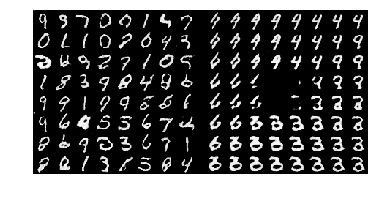

In [7]:
generator, discriminator = Generator(), Discriminator()
gen_optimiser = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
disc_optimiser = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))

plt.axis('off')

def train():
    for i, (real_x, _) in enumerate(train_loader):
        disc_optimiser.zero_grad()
        real_y = discriminator(real_x)
        real_loss = F.binary_cross_entropy(real_y, torch.ones_like(real_y))
        real_loss.backward()
        noise = torch.randn(batch_size, latent_size)
        fake_x = generator(noise)
        fake_y = discriminator(fake_x.detach())
        fake_loss = F.binary_cross_entropy(fake_y, torch.zeros_like(fake_y))       
        fake_loss.backward()
        disc_optimiser.step()

        gen_optimiser.zero_grad()
        fake_y = discriminator(fake_x)
        fake_loss = F.binary_cross_entropy(fake_y, torch.ones_like(fake_y))       
        fake_loss.backward()
        gen_optimiser.step()        


def sample():
    generator.eval()
    with torch.no_grad():
        samples = make_grid(generator(z_samples), padding=0)
        interps = make_grid(generator(z_interp), padding=0)
        plt.imshow(np.transpose(torch.cat([samples, black_bar, interps], 2).numpy(), [1, 2, 0]))
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.1)
        

for epoch in range(epochs):
    train()
    sample()
clear_output(wait=True)

Compare the GAN samples to the VAE samples. Although it isn't a completely fair comparison, VAE samples tend to be more globally coherent, but blurrier. This is because the typical VAE reconstruction loss optimises each pixel independently, leading towards values that kind of work well on average (consider modelling a multimodal distribution with a unimodal distribution). On the other hand, the discriminator is after samples that look like they've come from the real distribution, leading towards finer textures or object boundaries in images.